In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import warnings
warnings.filterwarnings("ignore")
import TinySleepNet
import wandb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import DatasetsPaco
from wandb.keras import WandbCallback
from plotUtils import *

In [2]:
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fcornetti (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
# parameters 
binary_labels = True
channels = ['F4'] # =>? ['C3','C4','O1','O2','LOC','ROC','CHIN1']
batch_size = 32

In [4]:
patient_1 = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG1.edf", channels=channels)
patient_2 = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG2.edf", channels=channels)
patient_3 = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG3.edf", channels=channels)
patient_4 = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG4.edf", channels=channels)
patient_5 = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG5.edf", channels=channels)
patient_6 = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG6.edf", channels=channels)
patient_7 = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG7.edf", channels=channels)
patient_8 = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG8.edf", channels=channels)
patient_9 = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG9.edf", channels=channels)


In [5]:
# parameters <= da integrare in una util con l'our generator?
# => safe computarlo cosí? o da dentro un metodo get della classe? =>
# non é neanche detto che debba essere il patient1
pts_per_epoch = patient_1.epochs.get_data().shape[-1] 
sampling_rate = int(patient_1.sampling_rate)
output_classes = len(patient_1.id_to_class_dict)

In [6]:
# same generator => ? cambiare porqué ahora sono todos los pacientes
def generator(patient):
    for x, y in patient:
        yield x,y

ds_1 = tf.data.Dataset.from_generator(lambda: generator(patient_1),output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)
ds_2 = tf.data.Dataset.from_generator(lambda: generator(patient_2), output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)
ds_3 = tf.data.Dataset.from_generator(lambda: generator(patient_3), output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)
ds_4 = tf.data.Dataset.from_generator(lambda: generator(patient_4), output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)
ds_5 = tf.data.Dataset.from_generator(lambda: generator(patient_5), output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)
ds_6 = tf.data.Dataset.from_generator(lambda: generator(patient_6), output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)
ds_7 = tf.data.Dataset.from_generator(lambda: generator(patient_7), output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)
ds_8 = tf.data.Dataset.from_generator(lambda: generator(patient_8), output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)
ds_9 = tf.data.Dataset.from_generator(lambda: generator(patient_9), output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)

In [7]:
# dataset concated => 

full_dataset = tf.data.experimental.sample_from_datasets(
    [ds_1, ds_2, ds_3, ds_4, ds_5, ds_6, ds_7, ds_8, ds_9]
)

In [8]:
# train test spliting => 

DATASET_SIZE = len(list(full_dataset))

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

# full_dataset = tf.data.TFRecordDataset(FLAGS.input_file)
# full_dataset = full_dataset.shuffle()

train_ds = full_dataset.take(train_size)
test_ds = full_dataset.skip(train_size)
valid_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [9]:
# comprobation =>
counter = 0
for i in valid_ds:
    # print(i)
    counter +=1
counter

36

In [10]:
model = TinySleepNet.TinySleepNet(sampling_rate, len(channels), output_classes)

In [11]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# history = model.fit(dataset, epochs=50, validation_data=val_dataset_generator, callbacks=[WandbCallback()])
history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[WandbCallback()])
model.summary()

Epoch 1/50
163/163 [==============================] - 63s 369ms/step - loss: 3.1257 - accuracy: 0.7712 - val_loss: 0.9967 - val_accuracy: 0.8446


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/50
163/163 [==============================] - 60s 353ms/step - loss: 0.7783 - accuracy: 0.8182 - val_loss: 0.4646 - val_accuracy: 0.8507
Epoch 3/50
163/163 [==============================] - 60s 353ms/step - loss: 0.4722 - accuracy: 0.8297 - val_loss: 0.5386 - val_accuracy: 0.7734
Epoch 4/50
163/163 [==============================] - 62s 362ms/step - loss: 0.4271 - accuracy: 0.8509 - val_loss: 0.4709 - val_accuracy: 0.8234
Epoch 5/50
163/163 [==============================] - 62s 358ms/step - loss: 0.4372 - accuracy: 0.8436 - val_loss: 0.6438 - val_accuracy: 0.7031
Epoch 6/50
163/163 [==============================] - 59s 342ms/step - loss: 0.4315 - accuracy: 0.8477 - val_loss: 0.4197 - val_accuracy: 0.8561
Epoch 7/50
163/163 [==============================] - 61s 358ms/step - loss: 0.4342 - accuracy: 0.8477 - val_loss: 0.5111 - val_accuracy: 0.7977
Epoch 8/50
163/163 [==============================] - 61s 359ms/step - loss: 0.4496 - accuracy: 0.8375 - val_loss: 0.4771 - val_ac

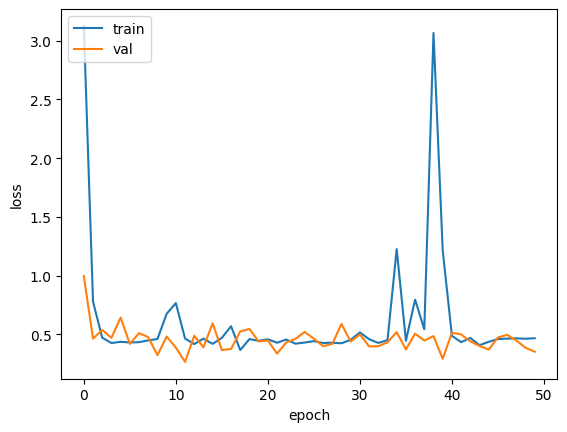

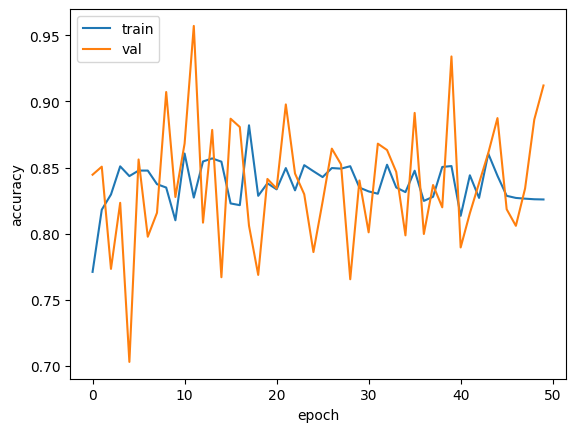

In [12]:
plot_history(history)

In [13]:
# test 

y_real = []
y_pred = []

for x, y in test_ds:
    y_real.extend(y.numpy())
    y_pred_batch = model.predict(x)
    y_pred_batch = np.argmax(y_pred_batch, axis=-1)
    y_pred.extend(y_pred_batch)

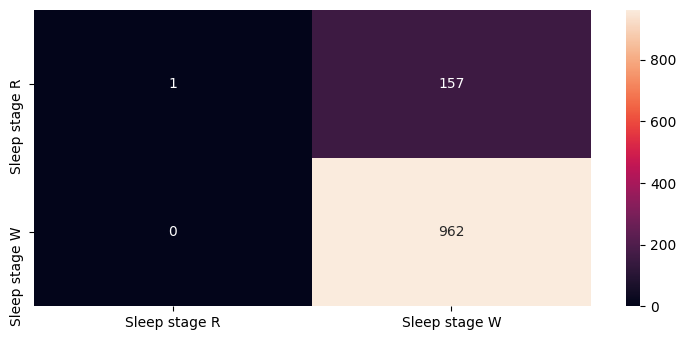

In [14]:
plot_cm(y_real, y_pred, patient_1.id_to_class_dict.values())

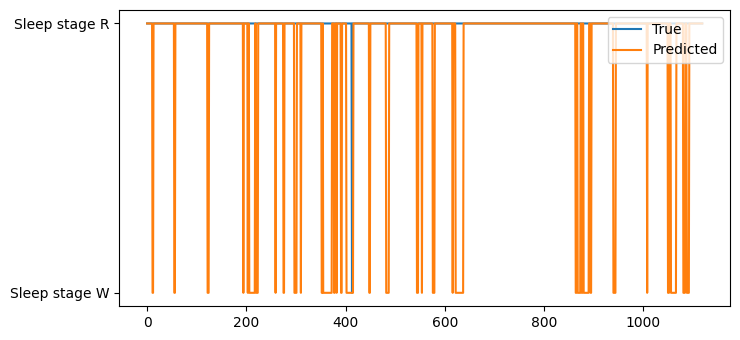

In [15]:
plot_hypnogram(y_real, y_pred, patient_1.id_to_class_dict)